In [10]:
# Cell 1: Import Libraries and Load Initial Data

import pandas as pd
import matplotlib.pyplot as plt

# Load polls and elections data
polls = pd.read_csv('data/house_polls_merged.csv')
elections = pd.read_csv('data/1976-2022-house.csv')

# Display initial information
print("Polls Data Columns:", polls.columns.tolist())
print("Elections Data Columns:", elections.columns.tolist())


Polls Data Columns: ['poll_id', 'pollster_id', 'pollster', 'sponsor_ids', 'sponsors', 'display_name', 'pollster_rating_id', 'pollster_rating_name', 'numeric_grade', 'pollscore', 'methodology', 'transparency_score', 'state', 'start_date', 'end_date', 'sponsor_candidate_id', 'sponsor_candidate', 'sponsor_candidate_party', 'endorsed_candidate_id', 'endorsed_candidate_name', 'endorsed_candidate_party', 'question_id', 'sample_size', 'population', 'subpopulation', 'population_full', 'tracking', 'created_at', 'notes', 'url', 'url_article', 'url_topline', 'url_crosstab', 'source', 'internal', 'partisan', 'race_id', 'cycle', 'office_type', 'seat_number', 'seat_name', 'election_date', 'stage', 'nationwide_batch', 'ranked_choice_reallocated', 'ranked_choice_round', 'hypothetical', 'party', 'answer', 'candidate_id', 'candidate_name', 'pct']
Elections Data Columns: ['year', 'state', 'state_po', 'state_fips', 'state_cen', 'state_ic', 'office', 'district', 'stage', 'runoff', 'special', 'candidate', '

In [11]:
# Cell 2: Load and Prepare Elections Data (2018-2022)

# Load elections data for 2018-2022
elections_2018_2022 = pd.read_csv('data/2018-2022-house.csv')

# Reset index for clean integer indexing
elections_2018_2022.reset_index(drop=True, inplace=True)

# Group elections by year, state, and district
election_groupby = elections_2018_2022.groupby(['year', 'state', 'district'])

# Display group information
print(f"Total Groups: {len(election_groupby)}")


Total Groups: 1306


In [12]:
print(set(elections_2018_2022['stage']))

{'GEN'}


In [ ]:
# Cell 4: Process Elections Data into Structured DataFrame

# Initialize a list to collect election rows
election_rows = []

# Iterate through each group to extract top two candidates
for group_key, group_df in election_groupby:
    # Ensure 'totalvotes' column exists
    # print(group_df)

    # Sort candidates by candidatevotes in descending order
    sorted_group = group_df.sort_values(by='candidatevotes', ascending=False)
    
    # Extract top candidate (c1)
    c1 = sorted_group.iloc[0]
    c1_name = c1['candidate']
    c1_party = c1['party']
    c1_votes = c1['candidatevotes']
    
    # Extract second candidate (c2) if exists
    if len(sorted_group) > 1:
        c2 = sorted_group.iloc[1]
        c2_name = c2['candidate']
        c2_party = c2['party']
        c2_votes = c2['candidatevotes']
    else:
        c2_name, c2_party, c2_votes = None, None, None
    
    # Determine winner
    winner = c1_name
    winner_party = c1_party
    
    # Append the row to the list
    election_rows.append([
        group_key[0],  # year
        group_key[1],  # state
        group_key[2],  # district
        c1_name,
        c2_name,
        c1_party,
        c2_party,
        c1_votes,
        c2_votes,
        winner,
        winner_party
    ])

# Create the elections DataFrame from the collected rows
election_df = pd.DataFrame(
    election_rows,
    columns=[
        'year', 'state', 'district',
        'c1', 'c2', 'c1_party', 'c2_party',
        'c1_votes', 'c2_votes',
        'winner', 'winner_party'
    ]
)

# Display the first few rows
print("Elections DataFrame Preview:")
print(election_df.head())

# Save the processed elections data to CSV
election_df.to_csv('data/elections-2018-2022.csv', index=False)
print("Processed elections data saved to 'data/elections-2018-2022.csv'")


Elections DataFrame Preview:
   year    state  district               c1                 c2    c1_party  \
0  2018  ALABAMA         1    BRADLEY BYRNE  ROBERT KENNEDY JR  REPUBLICAN   
1  2018  ALABAMA         2      MARTHA ROBY      TABITHA ISNER  REPUBLICAN   
2  2018  ALABAMA         3      MIKE ROGERS      MALLORY HAGAN  REPUBLICAN   
3  2018  ALABAMA         4  ROBERT ADERHOLT          LEE AUMAN  REPUBLICAN   
4  2018  ALABAMA         5        MO BROOKS     PETER JOFFRION  REPUBLICAN   

   c2_party  c1_votes  c2_votes           winner winner_party  
0  DEMOCRAT    153228   89226.0    BRADLEY BYRNE   REPUBLICAN  
1  DEMOCRAT    138879   86931.0      MARTHA ROBY   REPUBLICAN  
2  DEMOCRAT    147770   83996.0      MIKE ROGERS   REPUBLICAN  
3  DEMOCRAT    184255   46492.0  ROBERT ADERHOLT   REPUBLICAN  
4  DEMOCRAT    159063  101388.0        MO BROOKS   REPUBLICAN  
Processed elections data saved to 'data/elections-2018-2022.csv'


In [14]:

election_df.to_csv('data/elections-2018-2022.csv', index=False)

In [15]:
polls = pd.read_csv('data/house_polls_merged.csv')
polls['candidate_name'] = polls['candidate_name'].apply(lambda x: x.upper())
polls['state'] = polls['state'].apply(lambda x: x.upper())

print(polls.columns)
groupby = polls.groupby(['state', 'seat_number', 'cycle'])

groups = list(groupby)


# atts that good be good (beyond obvious):
# poll_id, pollster_id, sponsor_id, pollster_rating_id, pollscore, methodology, transparency score, sample_size, partisan
# sample_size

poll_df = pd.DataFrame(columns=['year', 'state', 'district', 'c1', 'c2', 'c1_party', 'c2_party', 'c1_pct', 'c2_pct'])


print(groups[0][0])
for group in groups:
    df = group[1]
    c1_idx = df['pct'].idxmax()
    c1 = df['candidate_name'][c1_idx]
    c1_party = df['party'][c1_idx]
    c1_pct = df['pct'][c1_idx]

    df = df.drop(index=c1_idx)
    try:
        c2_idx = df['pct'].idxmax()
        c2 = df['candidate_name'][c2_idx]
        c2_party = df['party'][c2_idx]
        c2_pct = df['pct'][c2_idx]
    except:
        c2, c2_party, c2_pct = None, None, None

   
    new_row = [group[0][2], group[0][0], group[0][1], c1, c2, c1_party, c2_party, c1_pct, c2_pct]
    poll_df.loc[len(poll_df)] = new_row





Index(['poll_id', 'pollster_id', 'pollster', 'sponsor_ids', 'sponsors',
       'display_name', 'pollster_rating_id', 'pollster_rating_name',
       'numeric_grade', 'pollscore', 'methodology', 'transparency_score',
       'state', 'start_date', 'end_date', 'sponsor_candidate_id',
       'sponsor_candidate', 'sponsor_candidate_party', 'endorsed_candidate_id',
       'endorsed_candidate_name', 'endorsed_candidate_party', 'question_id',
       'sample_size', 'population', 'subpopulation', 'population_full',
       'tracking', 'created_at', 'notes', 'url', 'url_article', 'url_topline',
       'url_crosstab', 'source', 'internal', 'partisan', 'race_id', 'cycle',
       'office_type', 'seat_number', 'seat_name', 'election_date', 'stage',
       'nationwide_batch', 'ranked_choice_reallocated', 'ranked_choice_round',
       'hypothetical', 'party', 'answer', 'candidate_id', 'candidate_name',
       'pct'],
      dtype='object')
('ALABAMA', 2, 2024)


In [16]:
print(poll_df.columns)
print(election_df.columns)

print(len(poll_df.values))



Index(['year', 'state', 'district', 'c1', 'c2', 'c1_party', 'c2_party',
       'c1_pct', 'c2_pct'],
      dtype='object')
Index(['year', 'state', 'district', 'c1', 'c2', 'c1_party', 'c2_party',
       'c1_votes', 'c2_votes', 'winner', 'winner_party'],
      dtype='object')
484


363


<Axes: >

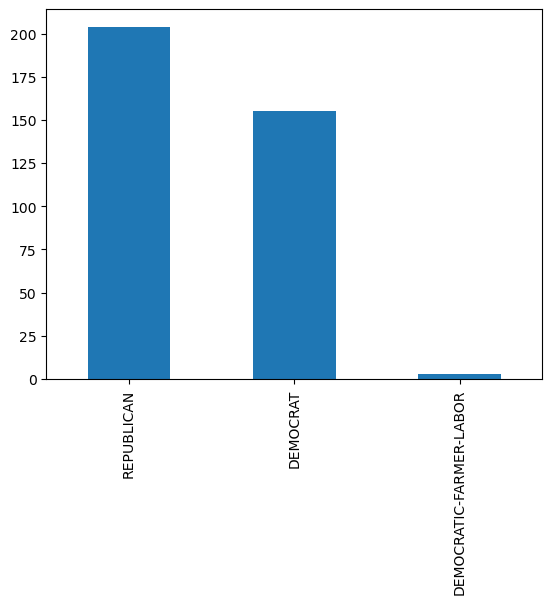

In [17]:
# joined_df = election_df.join(poll_df, on=['year', 'state', 'district'], how='inner')

joined_df = pd.merge(election_df, poll_df, on=['year', 'state', 'district'])

print(len(joined_df.values))

joined_df.to_csv('joined_table.csv')


joined_df['winner_party'].value_counts().plot(kind='bar')


